# Usage example

To showcase the use of this toolkit, we first create a simple learning task, and then learn an OOM model using spectral learning.

We start by importing the toolkit and initializing a random generator.

In [1]:
import tom
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
rand = tom.Random(1234567)

## 1. The learning task

First, we randomly create a 7-dimensional OOM with an alphabet size of $|\Sigma| = 5$. This describes a stationary and ergodic symbol process. We sample a training sequence of length $10^6$ and five test sequences each of length $10^4$.

We will use initial subsequences of the training sequence of increasing lengths $\{10^3, 10^{3.5}, 10^4, 10^{4.5}, 10^{5}, 10^{5.5}, 10^6 \}$ as data for the OOM estimation, and test the performance of the learnt models on the test sequences by computing the time-averaged negative $\log_2$-likelihood.

In [2]:
oom = tom.Oom(7, 5, 0, 10, rand)
train_sequence = oom.sample(10**6, rand)
test_sequences = []
for i in range(5):
    oom.reset()
    test_sequences.append(oom.sample(10**4, rand))
train_lengths = [int(10**(k/2)) for k in range(6,13)]

## 2. Performing spectral learning

Spectral learning requires the following steps. For details consult the publication: [Michael Thon and Herbert Jaeger. Links between multiplicity automata, observable operator models and predictive state representations -- a unified learning framework. Journal of Machine Learning Research, 16:103–147, 2015](http://jmlr.org/papers/v16/thon15a.html).


1. For words $\bar{x}\in\Sigma^*$, estimate from the available data the values $\hat{f}(\bar{x})$, where $f(\bar{x}) = P(\bar{x})$ is the stationary probability of observing $\bar{x}$. This is accomplished  by a `tom.Estimator` object, which uses a suffix tree representation of the data in the form of a `tom.STree` to compute these estimates efficiently.

2. Select sets $X, Y \subseteq \Sigma^*$ of "indicative" and "characteristic" words that determine which of the above estimates will be used for the spectral learning. Here, we will use the at most 1000 words occurring most often in the training sequence. This is computed efficiently by the function `tom.getWordsFromData` from a suffix tree representation of the training data.

3. Estimate an appropriate target dimension $d$ by the *numerical rank* of the matrix $\hat{F}^{Y,X} = [\hat{f}(\bar{x}\bar{y})]_{\bar{y}\in Y, \bar{x}\in X}$.

4. Perform the actual spectral learning using the function `tom.learn.spectral`. This consists of the following steps:
    - Find the best rank-$d$ approximation $BA \approx \hat{F}^{Y,X}$ to the matrix $\hat{F}^{Y,X}$.
    - Project the columns of $\hat{F}^{Y,X}$ and $\hat{F}_z^{Y,X} = [\hat{f}(\bar{x} z \bar{y})]_{\bar{y}\in Y, \bar{x}\in X}$, as well as the vector $\hat{F}^{X, \varepsilon} = [\hat{f}(\bar{x})]_{\bar{x}\in X}$ to the principal subspace spanned by $B$, giving the coordinate representations $A$, $A_z$ and $\hat{\omega}_\varepsilon$, respectively.
    - Solve $\hat{\tau_z} A = A_z$ in the least-squares sense for each symbol $z\in \Sigma$, as well as $\hat{\sigma} A = \hat{F}^{\varepsilon, Y} = [\hat{f}(\bar{y})]^\top_{\bar{y}\in Y}$.

This is performed once for each training sequence length.

In [3]:
# Initialize a suffix tree for the training data on an initial sequence of length zero.
stree = tom.STree(train_sequence.sub(0,0))

# For every training sequence length, learn a model via spectral learning
learnt_ooms = []
for train_length in train_lengths:
    # Extend the suffix tree representation to the current training sequence length:
    stree.extendTo(train_sequence.sub(0, train_length))
    
    # 1. Get an estimator object to compute the desired estimates:
    estimator = tom.Estimator(stree)
    
    # 2. Select sets of indicative and characteristic words:
    X = Y = tom.wordsFromData(stree, maxWords = 1000)
    
    # 3. Estimate an appropriate target dimension:
    d = tom.learn.estimateDimension(estimator, X, Y)
    
    # 4. Perform spectral learning to estimate an OOM:
    learnt_oom = tom.learn.spectral(estimator, X, Y, dimension = d)
    learnt_ooms.append(learnt_oom)

    # Print a very simple progress indicator:
    print('.', end='', flush=True)
print('done!')

.......done!


## 3. Evaluate the learnt models and plot the results

We first print the estimated model dimension to see if the dimension estimation has produced reasonable values.

Next we evaluate the learnt models by computing the time-averaged negative $\log_2$-likelihood (cross-entropy) on the test sequences by the member function `Oom.l2l(test_sequence)`. Note that a value of $\log_2(|\Sigma|) \approx 2.32$ corresponds to pure chance level (i.e., a model guessing the next symbol uniformly randomly). Furthermore, we can estimate the best possible value by computing the time-averaged negative $\log_2$-"likelihood" of the true model on the test sequences, which samples the entropy of the stochastic process.

We then plot the performance of the estimated models (y-axis), where we scale the plot such that the minimum corresponds to the best possible model, and the maximum corresponds to pure chance.

In [5]:
# Let's examine the estimated model dimensions:
print('Estimated model dimensions: ', [learnt_oom.dimension() for learnt_oom in learnt_ooms])

Estimated model dimensions:  [9, 6, 6, 6, 6, 6, 7]


In [6]:
# The time-averaged negative log2-likelihood is computed by the function `oom.l2l(test_sequence)`.
results = [np.average([ learnt_oom.l2l(test_sequence) for test_sequence in test_sequences ])
           for learnt_oom in learnt_ooms]

# Compute an approximation to the optimum value:
l2l_opt = np.average([oom.l2l(test_sequence) for test_sequence in test_sequences])

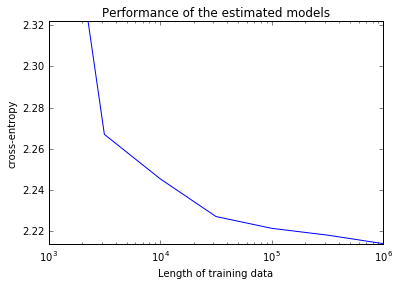

In [7]:
# Plot the performance of the estimated models:
plt.semilogx(train_lengths, results);
plt.xlim((train_lengths[0], train_lengths[-1]));
plt.ylim((l2l_opt, np.log2(5)));
plt.title('Performance of the estimated models');
plt.ylabel('cross-entropy');
plt.xlabel('Length of training data');

As we can see, spectral learning requires a fairly large amount of training data to estimate a model that is better than chance level, but the model estimation does converge to a perfect model as the amont of training data increases.